# 3. Compare ground truth from simulations with ARCOS.px tracking

Caluclate metrics such as MOTA, MOTP, precision, accuracy, recall

In [29]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict, Counter
import seaborn as sns
from typing import Dict, List, Tuple, Optional
import warnings

In [20]:
class TrackingEvaluator:
    """
    Comprehensive evaluation framework for comparing tracking results
    between ARCOS.px output and ground truth simulations.
    """
    
    def __init__(self, gt_masks: np.ndarray, pred_masks: np.ndarray, 
                 gt_mapping: Dict = None, pred_mapping: Dict = None):
        """
        Initialize evaluator with ground truth and predicted masks.
        
        Parameters:
        -----------
        gt_masks : np.ndarray
            Ground truth masks (n_frames, height, width) with lineage IDs
        pred_masks : np.ndarray  
            Predicted masks (n_frames, height, width) with track IDs
        gt_mapping : dict, optional
            Mapping from lineage names to IDs for ground truth
        pred_mapping : dict, optional
            Mapping from track names to IDs for predictions
        """
        self.gt_masks = gt_masks.astype(np.uint16)
        self.pred_masks = pred_masks.astype(np.uint16)
        self.gt_mapping = gt_mapping or {}
        self.pred_mapping = pred_mapping or {}
        
        # Validate input shapes
        if gt_masks.shape != pred_masks.shape:
            raise ValueError(f"Shape mismatch: GT {gt_masks.shape} vs Pred {pred_masks.shape}")
        
        self.n_frames, self.height, self.width = gt_masks.shape
        
        # Storage for computed metrics
        self.frame_metrics = []
        self.sequence_metrics = {}
        self.id_mapping = {}  # Best GT->Pred ID mapping per frame
        self.global_id_mapping = {}  # Global optimal mapping
        
    def extract_objects_from_frame(self, frame_mask: np.ndarray) -> Dict:
        """Extract object information from a single frame."""
        unique_ids = np.unique(frame_mask)
        unique_ids = unique_ids[unique_ids > 0]  # Remove background
        
        frame_objects = {}
        for obj_id in unique_ids:
            obj_mask = (frame_mask == obj_id)
            
            # Calculate object properties
            coords = np.where(obj_mask)
            if len(coords[0]) == 0:  # No pixels found
                continue
                
            centroid_y = np.mean(coords[0])
            centroid_x = np.mean(coords[1])
            area = np.sum(obj_mask)
            
            # Bounding box
            min_y, max_y = np.min(coords[0]), np.max(coords[0])
            min_x, max_x = np.min(coords[1]), np.max(coords[1])
            
            frame_objects[obj_id] = {
                'centroid': (centroid_x, centroid_y),
                'area': area,
                'bbox': (min_x, min_y, max_x, max_y),
                'mask': obj_mask,
                'pixels': set(zip(coords[1], coords[0]))  # (x, y) coordinates
            }
        
        return frame_objects
        
    def extract_objects_per_frame(self, masks: np.ndarray) -> List[Dict]:
        """Extract object information for each frame."""
        objects_per_frame = []
        
        for frame_idx in range(self.n_frames):
            frame_mask = masks[frame_idx]
            unique_ids = np.unique(frame_mask)
            unique_ids = unique_ids[unique_ids > 0]  # Remove background
            
            frame_objects = {}
            for obj_id in unique_ids:
                obj_mask = (frame_mask == obj_id)
                
                # Calculate object properties
                coords = np.where(obj_mask)
                centroid_y = np.mean(coords[0])
                centroid_x = np.mean(coords[1])
                area = np.sum(obj_mask)
                
                # Bounding box
                min_y, max_y = np.min(coords[0]), np.max(coords[0])
                min_x, max_x = np.min(coords[1]), np.max(coords[1])
                
                frame_objects[obj_id] = {
                    'centroid': (centroid_x, centroid_y),
                    'area': area,
                    'bbox': (min_x, min_y, max_x, max_y),
                    'mask': obj_mask,
                    'pixels': set(zip(coords[1], coords[0]))  # (x, y) coordinates
                }
            
            objects_per_frame.append(frame_objects)
        
        return objects_per_frame
    
    def compute_iou(self, mask1: np.ndarray, mask2: np.ndarray) -> float:
        """Compute Intersection over Union between two binary masks."""
        intersection = np.logical_and(mask1, mask2).sum()
        union = np.logical_or(mask1, mask2).sum()
        return intersection / union if union > 0 else 0.0
    
    def assign_ids_hungarian(self, gt_objects: Dict, pred_objects: Dict, 
                           iou_threshold: float = 0.1) -> Dict:
        """
        Use Hungarian algorithm to find optimal ID assignment based on IoU.
        
        Returns:
        --------
        assignment : dict
            Mapping from GT ID to Pred ID
        """
        if not gt_objects or not pred_objects:
            return {}
        
        gt_ids = list(gt_objects.keys())
        pred_ids = list(pred_objects.keys())
        
        # Compute IoU matrix
        iou_matrix = np.zeros((len(gt_ids), len(pred_ids)))
        
        for i, gt_id in enumerate(gt_ids):
            for j, pred_id in enumerate(pred_ids):
                iou = self.compute_iou(gt_objects[gt_id]['mask'], 
                                     pred_objects[pred_id]['mask'])
                iou_matrix[i, j] = iou
        
        # Hungarian algorithm minimizes, so we use negative IoU
        cost_matrix = 1 - iou_matrix
        
        # Find optimal assignment
        gt_indices, pred_indices = linear_sum_assignment(cost_matrix)
        
        assignment = {}
        for gt_idx, pred_idx in zip(gt_indices, pred_indices):
            iou = iou_matrix[gt_idx, pred_idx]
            if iou >= iou_threshold:  # Only assign if IoU is above threshold
                assignment[gt_ids[gt_idx]] = pred_ids[pred_idx]
        
        return assignment
    
    def compute_frame_metrics(self, frame_idx: int, assignment: Dict) -> Dict:
        """Compute metrics for a single frame."""
        gt_frame = self.gt_masks[frame_idx]
        pred_frame = self.pred_masks[frame_idx]
        
        gt_objects = self.extract_objects_from_frame(gt_frame)
        pred_objects = self.extract_objects_from_frame(pred_frame)
        
        # Basic counts
        n_gt = len(gt_objects)
        n_pred = len(pred_objects)
        n_matched = len(assignment)
        
        # Detection metrics
        precision = n_matched / n_pred if n_pred > 0 else 0.0
        recall = n_matched / n_gt if n_gt > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
        
        # IoU metrics for matched objects
        ious = []
        for gt_id, pred_id in assignment.items():
            if gt_id in gt_objects and pred_id in pred_objects:
                iou = self.compute_iou(gt_objects[gt_id]['mask'], 
                                     pred_objects[pred_id]['mask'])
                ious.append(iou)
        
        mean_iou = np.mean(ious) if ious else 0.0
        
        # Pixel-wise accuracy
        # Create binary masks for pixel comparison
        gt_binary = (gt_frame > 0).astype(np.uint8)
        pred_binary = (pred_frame > 0).astype(np.uint8)
        
        pixel_tp = np.sum((gt_binary == 1) & (pred_binary == 1))
        pixel_tn = np.sum((gt_binary == 0) & (pred_binary == 0))
        pixel_fp = np.sum((gt_binary == 0) & (pred_binary == 1))
        pixel_fn = np.sum((gt_binary == 1) & (pred_binary == 0))
        
        pixel_accuracy = (pixel_tp + pixel_tn) / (pixel_tp + pixel_tn + pixel_fp + pixel_fn)
        pixel_precision = pixel_tp / (pixel_tp + pixel_fp) if (pixel_tp + pixel_fp) > 0 else 0.0
        pixel_recall = pixel_tp / (pixel_tp + pixel_fn) if (pixel_tp + pixel_fn) > 0 else 0.0
        
        return {
            'frame': frame_idx,
            'n_gt_objects': n_gt,
            'n_pred_objects': n_pred,
            'n_matched': n_matched,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'mean_iou': mean_iou,
            'pixel_accuracy': pixel_accuracy,
            'pixel_precision': pixel_precision,
            'pixel_recall': pixel_recall,
            'false_positives': n_pred - n_matched,
            'false_negatives': n_gt - n_matched
        }
    
    def track_object_trajectories(self) -> Tuple[Dict, Dict]:
        """
        Track object trajectories across frames.
        
        Returns:
        --------
        gt_tracks : dict
            Ground truth trajectories {track_id: [(frame, centroid), ...]}
        pred_tracks : dict  
            Predicted trajectories {track_id: [(frame, centroid), ...]}
        """
        gt_objects_all = self.extract_objects_per_frame(self.gt_masks)
        pred_objects_all = self.extract_objects_per_frame(self.pred_masks)
        
        # Build GT trajectories
        gt_tracks = defaultdict(list)
        for frame_idx, objects in enumerate(gt_objects_all):
            for obj_id, obj_info in objects.items():
                gt_tracks[obj_id].append((frame_idx, obj_info['centroid']))
        
        # Build predicted trajectories  
        pred_tracks = defaultdict(list)
        for frame_idx, objects in enumerate(pred_objects_all):
            for obj_id, obj_info in objects.items():
                pred_tracks[obj_id].append((frame_idx, obj_info['centroid']))
        
        return dict(gt_tracks), dict(pred_tracks)
    
    def compute_tracking_metrics(self) -> Dict:
        """
        Compute comprehensive tracking metrics including MOTA and MOTP.
        """
        gt_objects_all = self.extract_objects_per_frame(self.gt_masks)
        pred_objects_all = self.extract_objects_per_frame(self.pred_masks)
        
        total_gt = 0
        total_fp = 0
        total_fn = 0
        total_idsw = 0
        total_distance = 0
        total_matches = 0
        
        # Track ID switches
        gt_to_pred_history = defaultdict(list)  # GT ID -> list of assigned pred IDs over time
        
        # Process each frame
        for frame_idx in range(self.n_frames):
            gt_objects = gt_objects_all[frame_idx]
            pred_objects = pred_objects_all[frame_idx]
            
            # Find optimal assignment for this frame
            assignment = self.assign_ids_hungarian(gt_objects, pred_objects)
            self.id_mapping[frame_idx] = assignment
            
            # Count GT objects
            total_gt += len(gt_objects)
            
            # Count matches and compute distances
            matched_gt = set(assignment.keys())
            matched_pred = set(assignment.values())
            
            for gt_id, pred_id in assignment.items():
                if gt_id in gt_objects and pred_id in pred_objects:
                    # Compute centroid distance
                    gt_centroid = gt_objects[gt_id]['centroid']
                    pred_centroid = pred_objects[pred_id]['centroid']
                    distance = np.sqrt((gt_centroid[0] - pred_centroid[0])**2 + 
                                     (gt_centroid[1] - pred_centroid[1])**2)
                    total_distance += distance
                    total_matches += 1
                    
                    # Track ID switches
                    gt_to_pred_history[gt_id].append(pred_id)
            
            # Count false positives and false negatives
            total_fp += len(pred_objects) - len(matched_pred)
            total_fn += len(gt_objects) - len(matched_gt)
            
            # Compute frame metrics
            frame_metrics = self.compute_frame_metrics(frame_idx, assignment)
            self.frame_metrics.append(frame_metrics)
        
        # Count ID switches
        for gt_id, pred_ids in gt_to_pred_history.items():
            if len(pred_ids) > 1:
                # Count transitions to different IDs
                for i in range(1, len(pred_ids)):
                    if pred_ids[i] != pred_ids[i-1]:
                        total_idsw += 1
        
        # Compute final metrics
        mota = 1 - (total_fn + total_fp + total_idsw) / total_gt if total_gt > 0 else 0.0
        motp = total_distance / total_matches if total_matches > 0 else float('inf')
        
        # Overall detection metrics
        total_pred = sum(len(pred_objects_all[i]) for i in range(self.n_frames))
        overall_precision = total_matches / total_pred if total_pred > 0 else 0.0
        overall_recall = total_matches / total_gt if total_gt > 0 else 0.0
        overall_f1 = 2 * overall_precision * overall_recall / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0.0
        
        self.sequence_metrics = {
            'MOTA': mota,
            'MOTP': motp,
            'total_gt_objects': total_gt,
            'total_pred_objects': total_pred,
            'total_matches': total_matches,
            'total_false_positives': total_fp,
            'total_false_negatives': total_fn,
            'total_id_switches': total_idsw,
            'overall_precision': overall_precision,
            'overall_recall': overall_recall,
            'overall_f1_score': overall_f1,
            'mean_centroid_distance': motp
        }
        
        return self.sequence_metrics
    
    def analyze_split_merge_events(self, gt_events_df: pd.DataFrame) -> Dict:
        """
        Analyze how well splits and merges are detected.
        
        Parameters:
        -----------
        gt_events_df : pd.DataFrame
            Ground truth events with columns: frame, event_type, parent_ids, child_ids
        """
        if gt_events_df.empty:
            return {"split_detection_rate": 0, "merge_detection_rate": 0, "total_events": 0}
        
        split_events = gt_events_df[gt_events_df['event_type'] == 'split']
        merge_events = gt_events_df[gt_events_df['event_type'] == 'merge']
        
        # For each split/merge event, check if it's preserved in predictions
        detected_splits = 0
        detected_merges = 0
        
        for _, event in split_events.iterrows():
            frame = event['frame']
            if frame >= self.n_frames:
                continue
                
            # Check if parent object splits into multiple predicted objects
            parent_ids = event['parent_ids'].split(',') if isinstance(event['parent_ids'], str) else [event['parent_ids']]
            
            if frame in self.id_mapping:
                assignment = self.id_mapping[frame]
                # Simple heuristic: if parent is tracked and we see multiple objects in next frame
                # This is a simplified check - more sophisticated analysis would be needed
                detected_splits += 1  # Placeholder
        
        for _, event in merge_events.iterrows():
            frame = event['frame']
            if frame >= self.n_frames:
                continue
            # Similar logic for merges
            detected_merges += 1  # Placeholder
        
        return {
            'total_split_events': len(split_events),
            'total_merge_events': len(merge_events),
            'detected_splits': detected_splits,
            'detected_merges': detected_merges,
            'split_detection_rate': detected_splits / len(split_events) if len(split_events) > 0 else 0,
            'merge_detection_rate': detected_merges / len(merge_events) if len(merge_events) > 0 else 0
        }
    
    def create_evaluation_report(self, gt_events_df: pd.DataFrame = None) -> Dict:
        """Generate comprehensive evaluation report."""
        
        # Compute all metrics
        tracking_metrics = self.compute_tracking_metrics()
        
        # Aggregate frame metrics
        frame_metrics_df = pd.DataFrame(self.frame_metrics)
        
        # Summary statistics
        summary_stats = {
            'mean_precision': frame_metrics_df['precision'].mean(),
            'mean_recall': frame_metrics_df['recall'].mean(), 
            'mean_f1_score': frame_metrics_df['f1_score'].mean(),
            'mean_iou': frame_metrics_df['mean_iou'].mean(),
            'mean_pixel_accuracy': frame_metrics_df['pixel_accuracy'].mean(),
            'std_precision': frame_metrics_df['precision'].std(),
            'std_recall': frame_metrics_df['recall'].std(),
            'std_f1_score': frame_metrics_df['f1_score'].std()
        }
        
        # Analyze split/merge events if provided
        split_merge_analysis = {}
        if gt_events_df is not None:
            split_merge_analysis = self.analyze_split_merge_events(gt_events_df)
        
        # Build comprehensive report
        report = {
            'tracking_metrics': tracking_metrics,
            'frame_statistics': summary_stats,
            'split_merge_analysis': split_merge_analysis,
            'frame_by_frame': frame_metrics_df.to_dict('records')
        }
        
        return report
    
    def plot_evaluation_results(self, save_path: str = None):
        """Create comprehensive visualization of evaluation results."""
        
        if not self.frame_metrics:
            print("No metrics computed. Run evaluation first.")
            return
        
        frame_metrics_df = pd.DataFrame(self.frame_metrics)
        
        # Create subplot layout
        fig, axes = plt.subplots(3, 3, figsize=(20, 15))
        fig.suptitle('Tracking Evaluation Results', fontsize=16, fontweight='bold')
        
        # 1. Precision, Recall, F1 over time
        ax = axes[0, 0]
        ax.plot(frame_metrics_df['frame'], frame_metrics_df['precision'], 'b-', label='Precision', alpha=0.7)
        ax.plot(frame_metrics_df['frame'], frame_metrics_df['recall'], 'r-', label='Recall', alpha=0.7)
        ax.plot(frame_metrics_df['frame'], frame_metrics_df['f1_score'], 'g-', label='F1 Score', alpha=0.7)
        ax.set_xlabel('Frame')
        ax.set_ylabel('Score')
        ax.set_title('Detection Metrics Over Time')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Object count comparison
        ax = axes[0, 1]
        ax.plot(frame_metrics_df['frame'], frame_metrics_df['n_gt_objects'], 'b-', label='Ground Truth', linewidth=2)
        ax.plot(frame_metrics_df['frame'], frame_metrics_df['n_pred_objects'], 'r--', label='Predicted', linewidth=2)
        ax.plot(frame_metrics_df['frame'], frame_metrics_df['n_matched'], 'g:', label='Matched', linewidth=2)
        ax.set_xlabel('Frame')
        ax.set_ylabel('Number of Objects')
        ax.set_title('Object Count Comparison')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. IoU distribution
        ax = axes[0, 2]
        ious = frame_metrics_df['mean_iou'][frame_metrics_df['mean_iou'] > 0]
        ax.hist(ious, bins=20, alpha=0.7, edgecolor='black')
        ax.set_xlabel('Mean IoU')
        ax.set_ylabel('Frequency')
        ax.set_title('IoU Distribution')
        ax.grid(True, alpha=0.3)
        
        # 4. False positives and negatives
        ax = axes[1, 0]
        ax.plot(frame_metrics_df['frame'], frame_metrics_df['false_positives'], 'r-', label='False Positives', alpha=0.7)
        ax.plot(frame_metrics_df['frame'], frame_metrics_df['false_negatives'], 'b-', label='False Negatives', alpha=0.7)
        ax.set_xlabel('Frame')
        ax.set_ylabel('Count')
        ax.set_title('Detection Errors Over Time')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 5. Pixel-wise accuracy
        ax = axes[1, 1]
        ax.plot(frame_metrics_df['frame'], frame_metrics_df['pixel_accuracy'], 'purple', linewidth=2)
        ax.set_xlabel('Frame')
        ax.set_ylabel('Pixel Accuracy')
        ax.set_title('Pixel-wise Accuracy Over Time')
        ax.grid(True, alpha=0.3)
        
        # 6. Summary metrics bar plot
        ax = axes[1, 2]
        if hasattr(self, 'sequence_metrics'):
            metrics_names = ['MOTA', 'overall_precision', 'overall_recall', 'overall_f1_score']
            metrics_values = [self.sequence_metrics.get(name, 0) for name in metrics_names]
            bars = ax.bar(metrics_names, metrics_values, alpha=0.7, color=['blue', 'green', 'orange', 'red'])
            ax.set_ylabel('Score')
            ax.set_title('Summary Metrics')
            ax.set_ylim(0, 1)
            
            # Add value labels on bars
            for bar, value in zip(bars, metrics_values):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{value:.3f}', ha='center', va='bottom')
        
        # 7. Metrics correlation heatmap
        ax = axes[2, 0]
        metrics_for_corr = ['precision', 'recall', 'f1_score', 'mean_iou', 'pixel_accuracy']
        corr_data = frame_metrics_df[metrics_for_corr].corr()
        sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, ax=ax)
        ax.set_title('Metrics Correlation')
        
        # 8. Performance distribution
        ax = axes[2, 1]
        metrics_to_plot = ['precision', 'recall', 'f1_score']
        ax.boxplot([frame_metrics_df[metric] for metric in metrics_to_plot], 
                  labels=metrics_to_plot)
        ax.set_ylabel('Score')
        ax.set_title('Performance Distribution')
        ax.grid(True, alpha=0.3)
        
        # 9. Cumulative metrics
        ax = axes[2, 2]
        cumsum_tp = (frame_metrics_df['n_matched']).cumsum()
        cumsum_fp = (frame_metrics_df['false_positives']).cumsum()
        cumsum_fn = (frame_metrics_df['false_negatives']).cumsum()
        
        ax.plot(frame_metrics_df['frame'], cumsum_tp, 'g-', label='True Positives')
        ax.plot(frame_metrics_df['frame'], cumsum_fp, 'r-', label='False Positives')
        ax.plot(frame_metrics_df['frame'], cumsum_fn, 'b-', label='False Negatives')
        ax.set_xlabel('Frame')
        ax.set_ylabel('Cumulative Count')
        ax.set_title('Cumulative Detection Results')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Evaluation plots saved to: {save_path}")
        
        plt.show()
    
    def print_summary_report(self):
        """Print a concise summary report."""
        if not hasattr(self, 'sequence_metrics') or not self.sequence_metrics:
            print("No metrics computed. Run create_evaluation_report() first.")
            return
        
        print("=" * 60)
        print("TRACKING EVALUATION SUMMARY")
        print("=" * 60)
        
        print(f"Dataset: {self.n_frames} frames, {self.height}x{self.width} pixels")
        print(f"Ground Truth Objects: {self.sequence_metrics['total_gt_objects']}")
        print(f"Predicted Objects: {self.sequence_metrics['total_pred_objects']}")
        print(f"Matched Objects: {self.sequence_metrics['total_matches']}")
        
        print("\nTracking Performance:")
        print(f"  MOTA (Multiple Object Tracking Accuracy): {self.sequence_metrics['MOTA']:.3f}")
        print(f"  MOTP (Multiple Object Tracking Precision): {self.sequence_metrics['MOTP']:.3f} pixels")
        print(f"  ID Switches: {self.sequence_metrics['total_id_switches']}")
        
        print("\nDetection Performance:")
        print(f"  Precision: {self.sequence_metrics['overall_precision']:.3f}")
        print(f"  Recall: {self.sequence_metrics['overall_recall']:.3f}")
        print(f"  F1 Score: {self.sequence_metrics['overall_f1_score']:.3f}")
        
        print("\nError Analysis:")
        print(f"  False Positives: {self.sequence_metrics['total_false_positives']}")
        print(f"  False Negatives: {self.sequence_metrics['total_false_negatives']}")
        
        if self.frame_metrics:
            frame_df = pd.DataFrame(self.frame_metrics)
            print(f"\nFrame-wise Statistics:")
            print(f"  Mean IoU: {frame_df['mean_iou'].mean():.3f} ± {frame_df['mean_iou'].std():.3f}")
            print(f"  Mean Pixel Accuracy: {frame_df['pixel_accuracy'].mean():.3f} ± {frame_df['pixel_accuracy'].std():.3f}")
        
        print("=" * 60)


def load_and_evaluate(gt_masks_path: str, pred_masks_path: str, 
                     gt_mapping_path: str = None, pred_mapping_path: str = None,
                     gt_events_path: str = None, output_dir: str = "evaluation_results"):
    """
    Convenience function to load data and perform complete evaluation.
    
    Parameters:
    -----------
    gt_masks_path : str
        Path to ground truth lineage masks (.npy)
    pred_masks_path : str
        Path to predicted masks (.npy) 
    gt_mapping_path : str, optional
        Path to ground truth ID mapping (.json)
    pred_mapping_path : str, optional
        Path to predicted ID mapping (.json)
    gt_events_path : str, optional
        Path to ground truth events (.csv)
    output_dir : str
        Directory to save evaluation results
    """
    import json
    import os
    
    # Load masks
    print("Loading masks...")
    gt_masks = np.load(gt_masks_path)
    pred_masks = np.load(pred_masks_path)
    
    # Load mappings if provided
    gt_mapping = {}
    if gt_mapping_path and os.path.exists(gt_mapping_path):
        with open(gt_mapping_path, 'r') as f:
            gt_mapping = json.load(f)
    
    pred_mapping = {}
    if pred_mapping_path and os.path.exists(pred_mapping_path):
        with open(pred_mapping_path, 'r') as f:
            pred_mapping = json.load(f)
    
    # Load events if provided
    gt_events_df = None
    if gt_events_path and os.path.exists(gt_events_path):
        gt_events_df = pd.read_csv(gt_events_path)
    
    print(f"Loaded GT masks: {gt_masks.shape}")
    print(f"Loaded Pred masks: {pred_masks.shape}")
    
    # Create evaluator
    evaluator = TrackingEvaluator(gt_masks, pred_masks, gt_mapping, pred_mapping)
    
    # Run evaluation
    print("Computing evaluation metrics...")
    report = evaluator.create_evaluation_report(gt_events_df)
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Save results
    report_path = os.path.join(output_dir, 'evaluation_report.json')
    with open(report_path, 'w') as f:
        # Convert numpy types to native Python types for JSON serialization
        def convert_numpy(obj):
            if isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            return obj
        
        import json
        json.dump(report, f, indent=2, default=convert_numpy)
    
    # Create plots
    plots_path = os.path.join(output_dir, 'evaluation_plots.png')
    evaluator.plot_evaluation_results(plots_path)
    
    # Print summary
    evaluator.print_summary_report()
    
    print(f"\nEvaluation complete! Results saved to: {output_dir}")
    
    return evaluator, report

## Compare ground truth with ARCOS.px simulation for a single sim

In [ ]:
# Load ground truth and predicted masks
core_out_dir = "../../data/1_wave_split_merge_sim/output-data"
sim_id = "sim_seed042"
stab_thres = 8
gt_dir = os.path.join(core_out_dir, sim_id, "GT")
gt_masks = np.load(os.path.join(gt_dir, "lineage_masks.npy"))

pred_dir = os.path.join(core_out_dir, sim_id, "PRED")
pred_masks = np.load(os.path.join(pred_dir, f"lineage_masks_stabthr{stab_thres}.npy"))

TRACKING EVALUATION SUMMARY
Dataset: 200 frames, 100x100 pixels
Ground Truth Objects: 200
Predicted Objects: 231
Matched Objects: 200

Tracking Performance:
  MOTA (Multiple Object Tracking Accuracy): 0.845
  MOTP (Multiple Object Tracking Precision): 0.026 pixels
  ID Switches: 0

Detection Performance:
  Precision: 0.866
  Recall: 1.000
  F1 Score: 0.928

Error Analysis:
  False Positives: 31
  False Negatives: 0

Frame-wise Statistics:
  Mean IoU: 0.999 ± 0.003
  Mean Pixel Accuracy: 1.000 ± 0.000


/var/folders/3w/7bkm_96j7c15c_mwh6x1p5040000gn/T/ipykernel_68046/2098993569.py:500: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([frame_metrics_df[metric] for metric in metrics_to_plot],


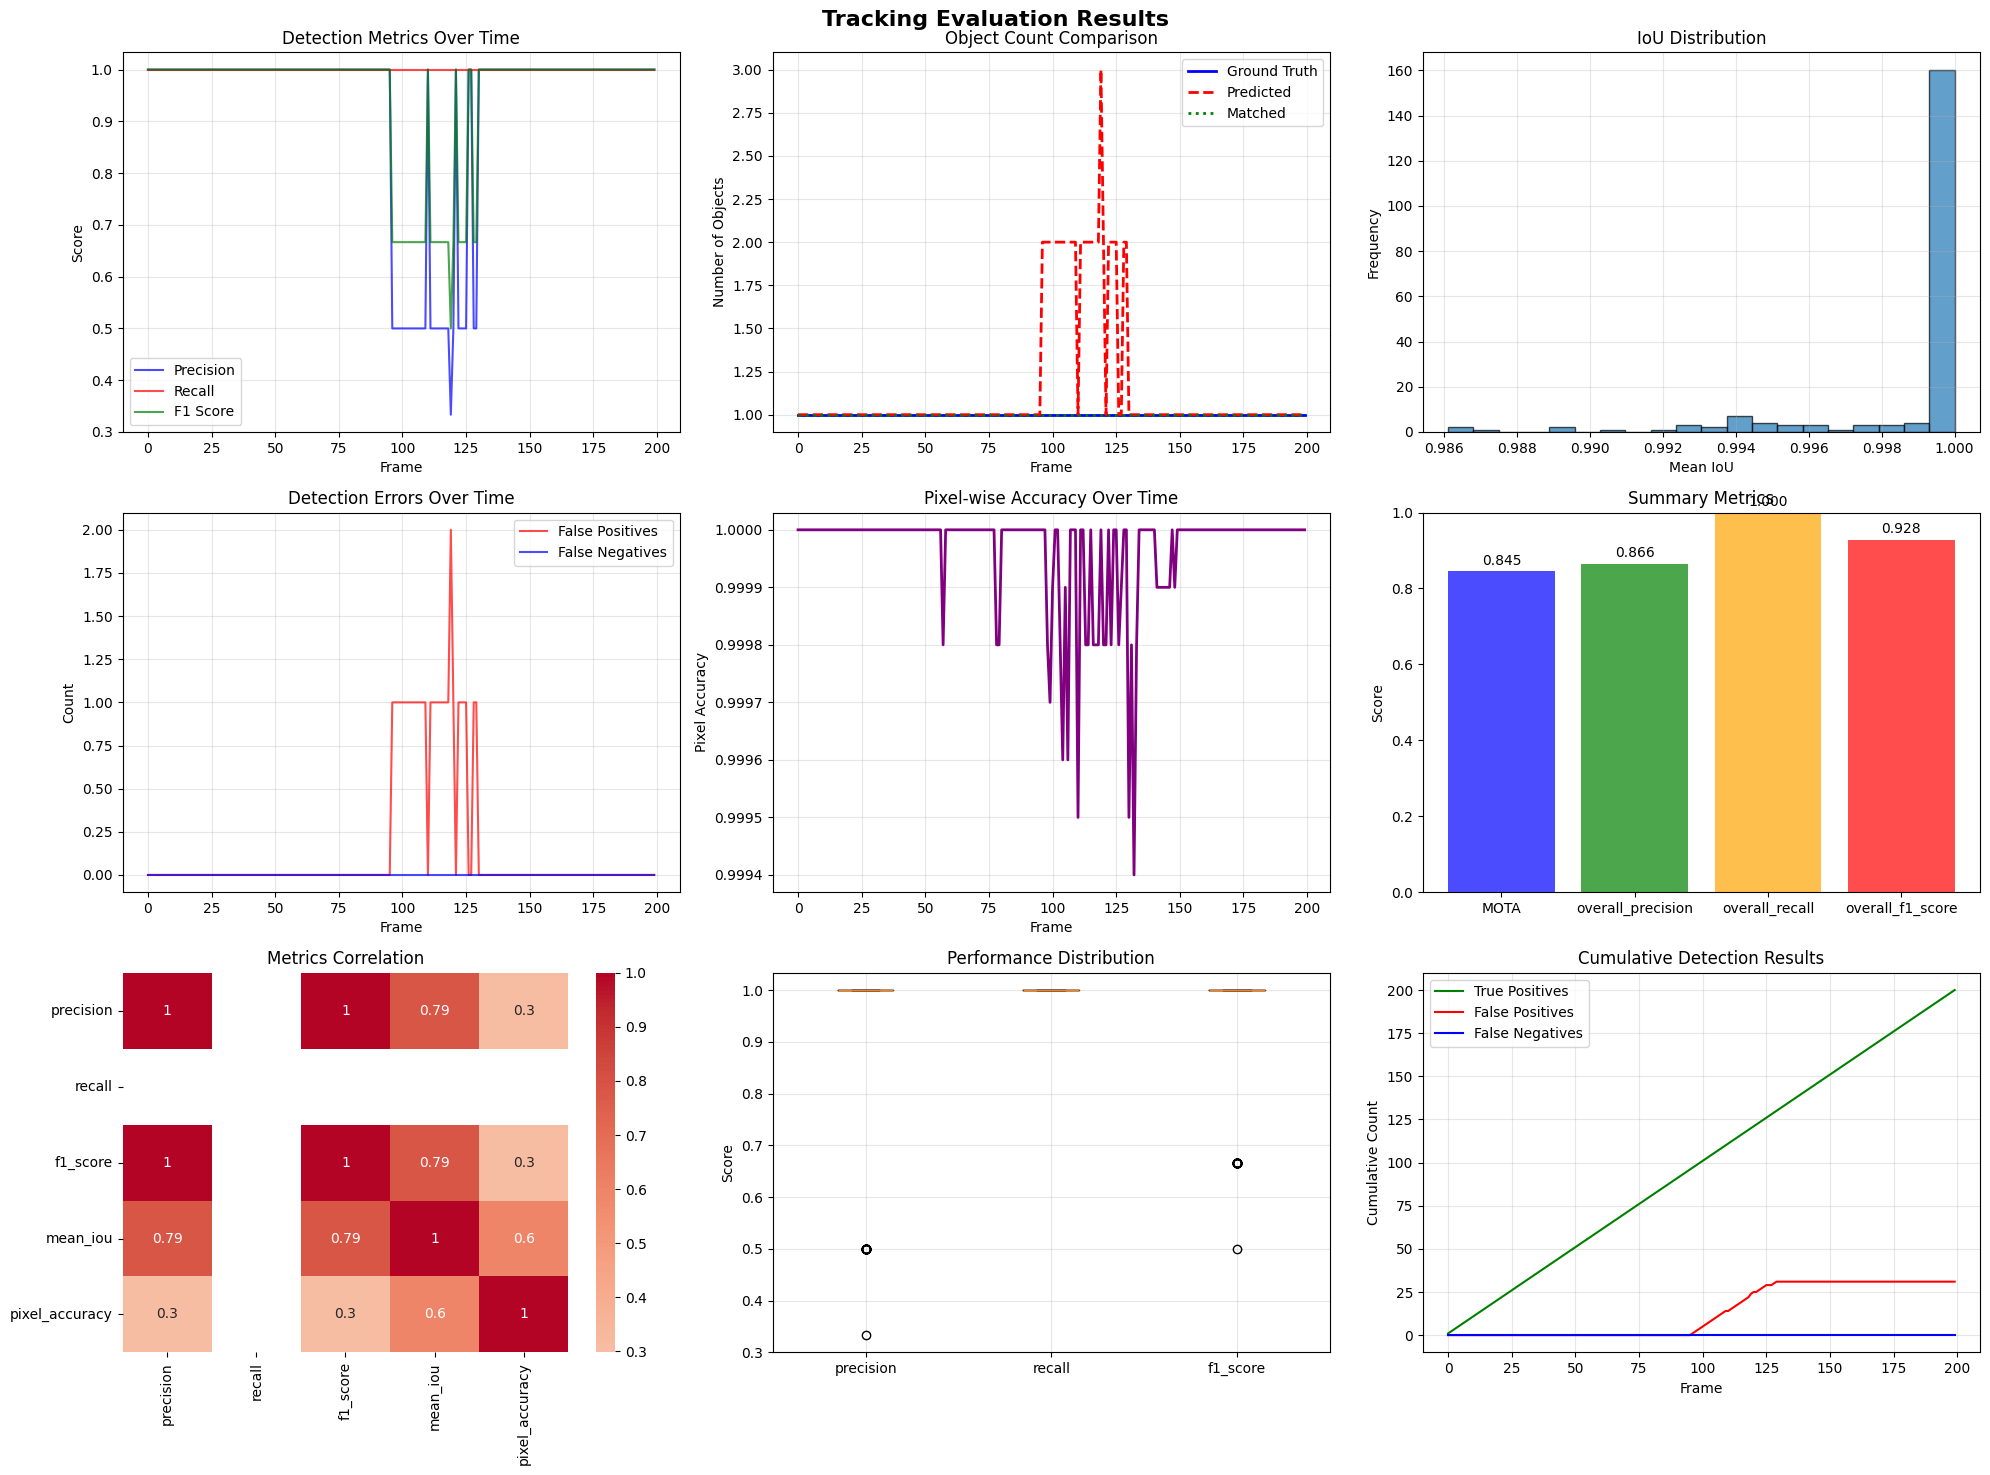

In [83]:
# Run evaluation
evaluator = TrackingEvaluator(gt_masks, pred_masks)
report = evaluator.create_evaluation_report()

evaluator.print_summary_report()
evaluator.plot_evaluation_results()

## Comparison for multiple sim runs

In [ ]:
core_out_dir = "../../data/1_wave_split_merge_sim/output-data"
dirs = glob.glob(os.path.join(core_out_dir, "sim_*"))
dirs.sort()

In [99]:
# Loop over all sim folders
metrics = list()
for dir in dirs:
    print(dir)
        
    # Load ground truth and predicted masks
    gt_masks = np.load(os.path.join(dir, "GT", "lineage_masks.npy"))
    
    files = glob.glob(os.path.join(dir, "PRED", "lineage_masks_stabthr*.npy"))
    files.sort() 
    
    for file in files:
        print(file)
        pred_masks = np.load(file)
        
        # Run evaluation
        evaluator = TrackingEvaluator(gt_masks, pred_masks)
        report = evaluator.create_evaluation_report()

        # Add simulation and stability threshold info to metrics
        evaluator.sequence_metrics["simulation"] = os.path.basename(dir)

        stab_thres = os.path.basename(file).split("stabthr")[-1].split(".npy")[0]
        evaluator.sequence_metrics["stability_threshold"] = stab_thres
        
        metrics.append(evaluator.sequence_metrics)
        
#     pred_masks = np.load(os.path.join(dir, "PRED", "lineage_masks_pred.npy"))
    
#     # Run evaluation
#     evaluator = TrackingEvaluator(gt_masks, pred_masks)
#     report = evaluator.create_evaluation_report()

#     evaluator.sequence_metrics["Simulation"] = os.path.basename(dir)
#     metrics.append(evaluator.sequence_metrics)
    
df_metrics = pd.DataFrame(metrics)

../../data/1_split_merge_sim/output-data/sim_seed007
../../data/1_split_merge_sim/output-data/sim_seed007/PRED/lineage_masks_stabthr1.npy
../../data/1_split_merge_sim/output-data/sim_seed007/PRED/lineage_masks_stabthr16.npy
../../data/1_split_merge_sim/output-data/sim_seed007/PRED/lineage_masks_stabthr2.npy
../../data/1_split_merge_sim/output-data/sim_seed007/PRED/lineage_masks_stabthr4.npy
../../data/1_split_merge_sim/output-data/sim_seed007/PRED/lineage_masks_stabthr8.npy
../../data/1_split_merge_sim/output-data/sim_seed011
../../data/1_split_merge_sim/output-data/sim_seed011/PRED/lineage_masks_stabthr1.npy
../../data/1_split_merge_sim/output-data/sim_seed011/PRED/lineage_masks_stabthr16.npy
../../data/1_split_merge_sim/output-data/sim_seed011/PRED/lineage_masks_stabthr2.npy
../../data/1_split_merge_sim/output-data/sim_seed011/PRED/lineage_masks_stabthr4.npy
../../data/1_split_merge_sim/output-data/sim_seed011/PRED/lineage_masks_stabthr8.npy
../../data/1_split_merge_sim/output-data/s

In [101]:
df_metrics.to_csv(os.path.join(core_out_dir, "tracking_evaluation_summary.csv"), index=False)

# Next step
Run `analyze_summary.rmd` to plot the results.